<a href="https://colab.research.google.com/github/shahafp/Conala-Challenge/blob/master/conala_tokenized_300b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import re
import torch
import numpy
from torch import autograd, nn, optim
import torch.nn.functional as F
import re
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import collections
import math
%matplotlib inline
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api
import gensim
import time
import math
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P4'

In [0]:
SOS_token = 0
EOS_token = 1
UNK_token = 2
MAX_LENGTH = 100

In [0]:
class VocabIntent :
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS",2: "UNK"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [0]:
class VocabCode:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS",2:"UNK"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in re.split('([^a-zA-Z0-9 ])',sentence):
          if word is not '':
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
def orginize_data(data_type):
  json_data = '/content/drive/My Drive/conala/' + data_type  
  path = open(json_data, "r")
  data = json.load(path)
  pairs=[]
  for dic in data:
      if dic["rewritten_intent"] is None:
          continue
      pairs.append([dic["rewritten_intent"], dic["snippet"]])
  return pairs

In [0]:
def prepare_data(vocab1_name, vocab2_name, data_type):
  pairs=orginize_data(data_type=data_type)
  intent_vocab=VocabIntent(vocab1_name)
  code_vocab=VocabCode(vocab2_name)

  for pair in pairs:
    intent_vocab.addSentence(pair[0])
    code_vocab.addSentence(pair[1])
  
  return intent_vocab, code_vocab, pairs

In [0]:
input_lang, output_lang, pairs= prepare_data('intent', 'code', 'conala-train.json')

In [0]:
#Load pre-trained embeddings
def getPreTrainedWeights():
  glove_file = datapath('/content/drive/My Drive/conala/glove.6B.300d.txt')
  tmp_file = get_tmpfile('/content/drive/My Drive/conala/glove.6B.300.w2v.txt')
  dim = glove2word2vec(glove_file, tmp_file)
  model = KeyedVectors.load_word2vec_format(tmp_file)
  return torch.FloatTensor(model.wv.vectors)

In [11]:
weights = getPreTrainedWeights()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding=nn.Embedding.from_pretrained(weights)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding.from_pretrained(weights)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
  return [lang.word2index[word] if word in lang.word2index else UNK_token for word in sentence.split(' ') ]

def c_indexesFromSentence(lang, sentence):
    sen = re.split('([^a-zA-Z0-9 ])',sentence)
    return [lang.word2index[word] for word in sen if word is not '']

def tensorFromSentence(lang, sentence, key):
    if key is 'intent':
      indexes = indexesFromSentence(lang, sentence)
      indexes.append(EOS_token)
    else:
      indexes = c_indexesFromSentence(lang, sentence)
      indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0], 'intent')
    target_tensor =tensorFromSentence(output_lang, pair[1], 'code')
    return (input_tensor, target_tensor)


In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

In [0]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, 'intent')
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
def evaluateRandomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

In [0]:
def evaluate_data_set(encoder, decoder, pairs, n=10):
  answer_list = []
  for i,pair in enumerate(pairs, 0):
      output_words, attentions = evaluate(encoder, decoder, pair[0])
      output_sentence = ''.join(output_words)
      output_sentence = output_sentence.strip('<EOS>')
      answer_list.append(output_sentence)
      if i%50==0:
        print('>', pair[0])
        print('=', pair[1])
        print('<', output_sentence)
        print('')
  return answer_list

In [26]:
hidden_size = 300
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

train_losses = trainIters(encoder1, attn_decoder1, 75000, print_every=100)


0m 10s (- 125m 12s) (100 0%) 5.4269
0m 13s (- 86m 28s) (200 0%) 4.8073
0m 17s (- 73m 22s) (300 0%) 4.4133
0m 21s (- 66m 1s) (400 0%) 3.8255
0m 24s (- 61m 39s) (500 0%) 4.0717
0m 28s (- 58m 8s) (600 0%) 3.8309
0m 31s (- 54m 55s) (700 0%) 3.7282
0m 34s (- 52m 42s) (800 1%) 3.7835
0m 37s (- 51m 35s) (900 1%) 3.8556
0m 41s (- 50m 38s) (1000 1%) 3.9422
0m 44s (- 49m 54s) (1100 1%) 3.8063
0m 47s (- 49m 4s) (1200 1%) 3.6181
0m 51s (- 48m 26s) (1300 1%) 3.7900
0m 54s (- 48m 4s) (1400 1%) 3.8880
0m 57s (- 47m 20s) (1500 2%) 3.5892
1m 0s (- 46m 35s) (1600 2%) 3.4579
1m 4s (- 46m 29s) (1700 2%) 3.6104
1m 7s (- 46m 4s) (1800 2%) 3.6024
1m 11s (- 45m 42s) (1900 2%) 3.6108
1m 14s (- 45m 36s) (2000 2%) 3.6731
1m 18s (- 45m 29s) (2100 2%) 3.7236
1m 21s (- 45m 3s) (2200 2%) 3.7307
1m 25s (- 44m 54s) (2300 3%) 3.7934
1m 28s (- 44m 44s) (2400 3%) 3.5104
1m 31s (- 44m 24s) (2500 3%) 3.7418
1m 35s (- 44m 11s) (2600 3%) 3.6365
1m 38s (- 43m 57s) (2700 3%) 3.5705
1m 42s (- 43m 53s) (2800 3%) 3.7761
1m 45s (-

<Figure size 432x288 with 0 Axes>

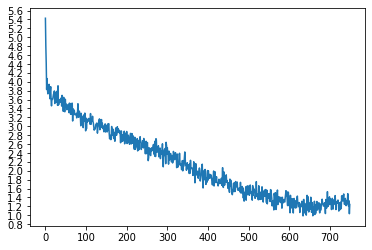

In [27]:
showPlot(train_losses)

In [28]:
# Train evaluation
evaluateRandomly(encoder1, attn_decoder1, pairs)

> create a dictionary `list_dict` containing each tuple in list `tuple_list` as values and the tuple's first element as the corresponding key
= list_dict = {t[0]: t for t in tuple_list}
< list( {x.[[x]:.)}<EOS>

> create list `changed_list ` containing elements of list `original_list` whilst converting strings containing digits to integers
= changed_list = [(int(f) if f.isdigit() else f) for f in original_list]
< changed_list = [(int(f) if f.isdigit() else f])<EOS>

> Check the status code of url `url`
= r = requests.head(url)
return (r.status_code == 200)
< r = requests.head(url)<EOS>

> SQLAlchemy select records of columns of table `my_table` in addition to current date column
= print(select([my_table, func.current_date()]).execute())
< print(select([my_table, func.current_date())]<EOS>

> Get a list from two strings `12345` and `ab` with values as each character concatenated
= [(x + y) for x in '12345' for y in 'ab']
< [(x + y) for x in '12345' for y in 'ab']<EOS>

> make a window `

In [29]:
train_answers = evaluate_data_set(encoder1,attn_decoder1, pairs)
acc = 0
# Compute how many full code line is the same as the data
for i in range(len(train_answers)):
  if pairs[i][1] == train_answers[i]:
    acc+=1
print("Correct on {} snippets out of {} on training set".format(acc,len(train_answers)))

> Concatenate elements of a list 'x' of multiple integers to a single integer
= sum(d * 10 ** i for i, d in enumerate(x[::-1]))
< sum(d * 10 ** i for i, d in enumerate(x[::-1]))

> execute os command ''TASKKILL /F /IM firefox.exe''
= os.system('TASKKILL /F /IM firefox.exe')
< os.system('TASKKILL /F /IM firefox.exe')

> trim whitespace in string `s`
= s.strip()
< s.strip()

> calculate the sum of the squares of each value in list `l`
= sum(map(lambda x: x * x, l))
< sum(map(lambda x: x * x, x[0]), l)

> sort list `lst` in descending order based on the second item of each tuple in it
= lst.sort(key=lambda x: x[2], reverse=True)
< lst.sort(key=lambda x: x[2]), x[1], x[0])

> check if any item from list `b` is in list `a`
= print(any(x in a for x in b))
< print(any(x in a for x in b))

> convert string `x'  to dictionary splitted by `=` using list comprehension
= dict([x.split('=') for x in s.split()])
< dict([xsplit='split''[split('split',split)))

> lowercase string values with key 'cont

In [34]:
test_pairs = orginize_data(data_type="conala-test.json")
answers = evaluate_data_set(encoder1,attn_decoder1, test_pairs)
snippet = [w[1] for w in test_pairs]

> send a signal `signal.SIGUSR1` to the current process
= os.kill(os.getpid(), signal.SIGUSR1)
< os.chdir('..)')

> parse milliseconds epoch time '1236472051807' to format '%Y-%m-%d %H:%M:%S'
= time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(1236472051807 / 1000.0))
< datetime.datetime(combine=ms / 1000.date

> create list `lst` containing 100 instances of object `Object`
= lst = [Object() for i in range(100)]
< [[[i][.[(:((]]]]]]]

> convert index at level 0 into a column in dataframe `df`
= df.reset_index(level=0, inplace=True)
< df.groupby('.columns).agg(['] axis+', axis=0)

> Removing duplicates in list `abracadabra`
= list(OrderedDict.fromkeys('abracadabra'))
< time.strftime(')

> sort a list `l` of dicts by dict value 'title'
= l.sort(key=lambda x: x['title'])
< sorted(the_list, key=lambda x: x(x.split('.')[:])[(])))))

> Django response with JSON `data`
= return HttpResponse(data, mimetype='application/json')
< data.rename('c')

> make a barplot of data in column `group` of dataf

In [35]:
c_snippet = [[c for c in s] for s in snippet]
c_answers = [[c for c in s] for s in answers]

score = 0
acc = 0
bleu_nltk = sentence_bleu
cc = SmoothingFunction()
# Compute score for every snippet and it's genarated code
for i in range(len(c_answers)):
  score += bleu_nltk([c_snippet[i]], c_answers[i], smoothing_function=cc.method4)
  if c_snippet[i] == c_answers[i]:
    acc+=1
print("Correct on {} snippets out of {} on training set".format(acc,len(c_answers)))
print("Avg Bleu score is: {}".format(score/len(answers)))

Correct on 0 snippets out of 477 on training set
Avg Bleu score is: 0.1357720257421837


In [47]:
ls = [["check if item from list `b` is in list `a`","print(x in a for x in b)"]]
n_lang = evaluate_data_set(encoder1,attn_decoder1, ls)

> check if item from list `b` is in list `a`
= print(x in a for x in b)
< print('['join()set(a))]

